In [1]:
# Importing Libraries
import csv
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Loading Data
DATA_PATH = r"C:\Users\Furio\Downloads\day_wise.csv"

def parse_data_from_file(filename, value_col="New deaths", date_col="Date"):
    df = pd.read_csv(filename, parse_dates=[date_col])
    SERIES = df[value_col].values
    TIMES = df[date_col].values
    return TIMES, SERIES

In [3]:
# Defining data and time
TIME, SERIES = parse_data_from_file(DATA_PATH)

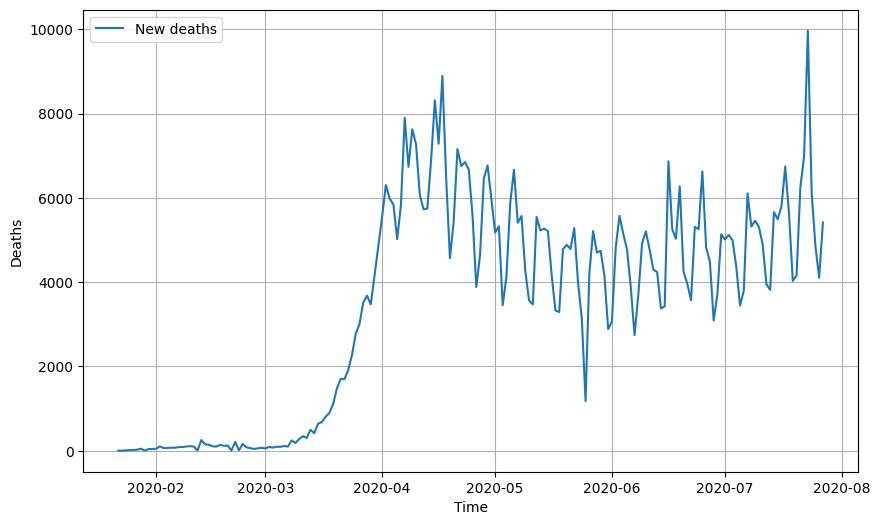

In [4]:
# Plotting the raw data
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Deaths")
    plt.grid(True)
    if label: plt.legend()

plt.figure(figsize=(10, 6))
plot_series(TIME, SERIES, label="New deaths")
plt.show()

In [5]:
# Saving all global variables
WINDOW_SMOOTH = 7
SPLIT_TIME = int(len(SERIES) * 0.8)
WINDOW_SIZE = 7
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [6]:
# Defining training and validation splits
def train_val_split(time, series):
    """ Splits time series into train and validations sets"""
    time_train = time[:SPLIT_TIME]
    series_train = series[:SPLIT_TIME]
    time_valid = time[SPLIT_TIME:]
    series_valid = series[SPLIT_TIME:]

    return time_train, series_train, time_valid, series_valid

In [7]:
# Setting the time and validation splits to the data
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)

"""
This step transforms the raw data from a large range to a much smaller range that will increase forecasting accuracy.
This is done on the train split only.
raw:   3000–10000
norm:  ~ -1.5 to +1.5
"""

# Normalize using TRAIN stats only (critical)
train_mean = series_train.mean()
train_std = series_train.std() + 1e-6

series_train_n = (series_train - train_mean) / train_std
series_valid_n = (series_valid - train_mean) / train_std


In [8]:
# Defining the model architecture
def create_uncompiled_model():
    return tf.keras.Sequential([
        tf.keras.Input(shape=(WINDOW_SIZE, 1)),
        tf.keras.layers.Conv1D(
            filters=32, kernel_size=3, padding="causal", activation="relu"
        ),
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(1)
    ])

In [9]:
# Get your uncompiled model
uncompiled_model = create_uncompiled_model()

In [10]:
# Defining a windows to shuffle 
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.convert_to_tensor(series, dtype=tf.float32)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(buffer_size=min(shuffle_buffer, max(1, int(series.shape[0]) - window_size)))
    ds = ds.map(lambda w: (tf.expand_dims(w[:-1], axis=-1), w[-1]))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [11]:
# Build datasets
train_dataset = windowed_dataset(series_train_n, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE).repeat()
valid_dataset = windowed_dataset(series_valid_n, WINDOW_SIZE, BATCH_SIZE, shuffle_buffer=1)

# Definiing the number of steps per epoch, preventing infinite loop
steps_per_epoch = max(1, (len(series_train_n) - WINDOW_SIZE) // BATCH_SIZE)
validation_steps = max(1, (len(series_valid_n) - WINDOW_SIZE) // BATCH_SIZE)

print("steps_per_epoch:", steps_per_epoch, "validation_steps:", validation_steps)

steps_per_epoch: 4 validation_steps: 1


In [12]:
# Create model using learning rate
def create_model():
    model = create_uncompiled_model()
    model.compile(
        loss=tf.keras.losses.Huber(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0),
        metrics=["mae"]
    )
    return model

model = create_model()

In [53]:
# Optional: Code to find and therefore adjust the learning rate
def adjust_learning_rate(dataset):
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))

    optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 

    history = model.fit(dataset, epochs=100,steps_per_epoch=steps_per_epoch, callbacks=[lr_schedule])
    
    return history

In [55]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_dataset)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4677 - mae: 0.8864 - learning_rate: 1.0000e-05
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4525 - mae: 0.8640 - learning_rate: 1.1220e-05
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4611 - mae: 0.8901 - learning_rate: 1.2589e-05
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4067 - mae: 0.8134 - learning_rate: 1.4125e-05
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4386 - mae: 0.8485 - learning_rate: 1.5849e-05
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4843 - mae: 0.9171 - learning_rate: 1.7783e-05
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4132 - mae: 0.7970 - learning_rate: 1.9953e-05
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4343 - mae: 0.8301 - learning_rate: 2.2387e-05
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4081 - mae: 0.8293 - learning_rate: 2.5119e-05
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms

In [57]:
# Desiginng callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True), # Prevents the model from overfitting 
]

In [59]:
# IMPORTANT: train using steps_per_epoch when dataset is repeated
history = model.fit(
    train_dataset,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0403 - mae: 0.1743 - val_loss: 0.0658 - val_mae: 0.2649
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0658 - mae: 0.2326 - val_loss: 0.0629 - val_mae: 0.2586
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0308 - mae: 0.1476 - val_loss: 0.0634 - val_mae: 0.2591
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0327 - mae: 0.1585 - val_loss: 0.0611 - val_mae: 0.2519
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0419 - mae: 0.1892 - val_loss: 0.0613 - val_mae: 0.2729
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0425 - mae: 0.2077 - val_loss: 0.0650 - val_mae: 0.2545
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0281 - mae: 0.1551 - val_loss: 0.0593 - val_mae: 0.2407
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0395 - mae: 0.1752 - val_loss: 0.0638 - val_mae: 0.2526
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0500 - mae: 0.2096 - 

In [61]:
def model_forecast(model, series, window_size):
    series = tf.convert_to_tensor(series, dtype=tf.float32)

    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.map(lambda w: tf.expand_dims(w, axis=-1))
    ds = ds.batch(32).prefetch(tf.data.AUTOTUNE)

    # returning the same thing as before: np array from predict
    return model.predict(ds, verbose=0)

In [97]:
BASE_SERIES = SERIES  
series_n = (BASE_SERIES - train_mean) / (train_std) # Cemters the data so typical values are around zero, with a deviation of ~ 1

forecast_input = series_n[SPLIT_TIME - WINDOW_SIZE:]  # Supplies the model data of window size length for forecasting context.
rnn_forecast_n = model_forecast(model, forecast_input, WINDOW_SIZE).squeeze() # Run the model to generate predictions 

# This ensures all predictions shown in the validation set only
rnn_forecast_n = rnn_forecast_n[-len(series_valid_n):]

# Converting from normalised values to normal values
rnn_forecast = rnn_forecast_n * (train_std) + train_mean

# --- Metrics (original units) ---
mae = tf.keras.losses.MAE(series_valid, rnn_forecast)

print(f"mae: {mae:.2f} for forecast")

mae: 761.82 for forecast


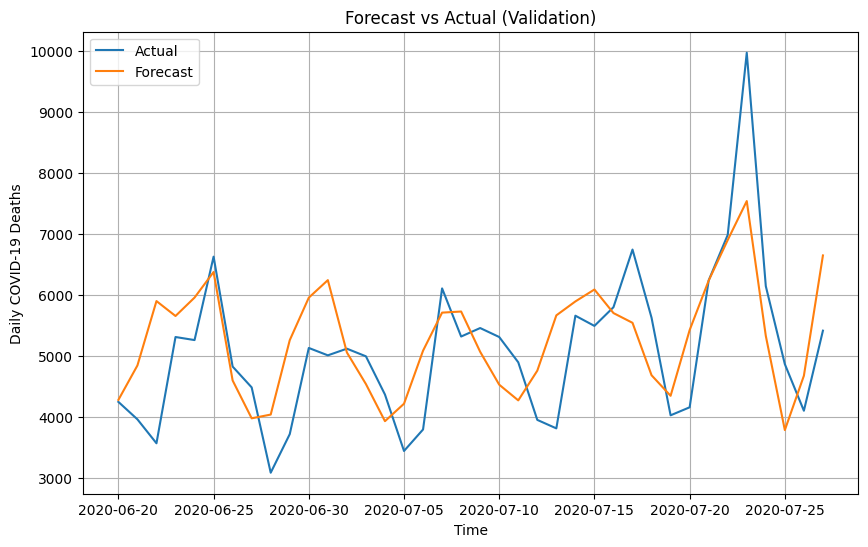

In [103]:
# ---- plot ----
plt.figure(figsize=(10, 6))
plt.plot(time_valid, series_valid, label="Actual")
plt.plot(time_valid, rnn_forecast, label="Forecast")
plt.grid(True)
plt.legend()
plt.title("Forecast vs Actual (Validation)")
plt.xlabel("Time")
plt.ylabel("Daily COVID-19 Deaths") 
plt.xticks(time_valid[::5])
plt.show()